<a href="https://colab.research.google.com/github/crismunoz/Fuzzy-Logic/blob/master/6_RulesExtraction/Fuzzy_Rules_(Guindaste).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Cristian Muñoz Villalobos

In [1]:
!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/guindaste.txt
!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
!pip install scikit-fuzzy

--2020-10-22 19:47:41--  https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/guindaste.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘guindaste.txt’

guindaste.txt       100%[===================>]     666  --.-KB/s    in 0s      

2020-10-22 19:47:42 (34.2 MB/s) - ‘guindaste.txt’ saved [666/666]

--2020-10-22 19:47:42--  https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4792 (4.7K) [tex

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import datetime
import pprint
import os

from operator import itemgetter
from itertools import groupby
from datetime import timedelta, date

from skfuzzy import control as ctrl
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable,define_input_variables,define_output_variables,read_dataset
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split

Read data with format (tab separator): 

In [2]:
cat guindaste.txt | head -5 

0,0	30,0	9,96
-3	21,43	12,75
-4	21,23	14,14
-5	21,02	15,54
-7	20,75	16,93


Text(0, 0.5, 'value')

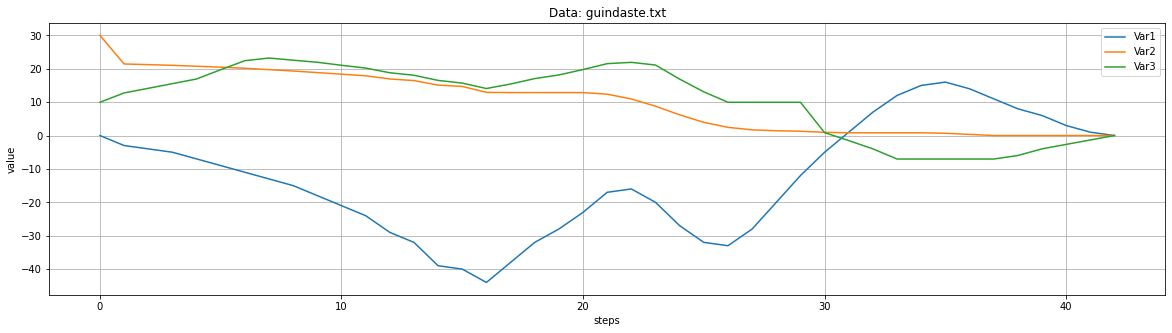

In [3]:
file_path='guindaste.txt'
data = read_dataset(file_path)
plt.figure(figsize=(20,5))
plt.title('Data: {}'.format(file_path))
plt.plot(data)
plt.grid()
plt.legend(['Var1','Var2','Var3'])
plt.xlabel('steps')
plt.ylabel('value')

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = np.stack([list(data) for data in dataset], axis=0)
X,y_true = dataset[:,:2],dataset[:,2:]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.20, shuffle=False)

print('-'*21+'\nDataset Distribution\n'+'-'*21)
print('X\t:{} | y_true\t:{}'.format(X.shape,y_true.shape))
print('X_train\t:{} | y_train\t:{}'.format(X_train.shape,y_train.shape))
print('X_test\t:{}  | y_test\t:{}'.format(X_test.shape,y_test.shape))

---------------------
Dataset Distribution
---------------------
X	:(43, 2) | y_true	:(43, 1)
X_train	:(34, 2) | y_train	:(34, 1)
X_test	:(9, 2)  | y_test	:(9, 1)


In [8]:
x_min_value = X.min(axis=0)
x_max_value = X.max(axis=0)
y_min_value = y_true.min(axis=0)
y_max_value = y_true.max(axis=0)

nb_inputs = X_train.shape[-1]
nb_outputs = y_train.shape[-1]

aggregation_opt={
'and_func':np.fmin,
'or_func': np.fmax
}

config = {

# Variable Parameters
'nb_inputs' : nb_inputs,
'nb_outputs': nb_outputs,
'nb_sets'   : [[6]*nb_inputs , [12]*nb_outputs],
'min'       : [x_min_value , y_min_value],
'max'       : [x_max_value , y_max_value],
'shoulder'  : True,

# Fuzzy System Parameters
'defuzzify_method' : 'centroid',
'aggregation_opt'  :  aggregation_opt,

# Fuzzy Rules Parameters
'intersection_op' : np.prod,

#Other Parametres
'resolution' : 1000,
'epsilon'    : 0.001
}

pp = pprint.PrettyPrinter(depth=6)
pp.pprint(config)
pp.pprint(aggregation_opt)

{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'centroid',
 'epsilon': 0.001,
 'intersection_op': <function prod at 0x7f70252c4048>,
 'max': [array([16., 30.]), array([23.21])],
 'min': [array([-44.,   0.]), array([-7.04])],
 'nb_inputs': 2,
 'nb_outputs': 1,
 'nb_sets': [[6, 6], [12]],
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}


In [9]:
antecedents = define_input_variables(config, shoulder=config['shoulder'])
consequents = define_output_variables(config, shoulder=config['shoulder'], defuzzify_method=config['defuzzify_method'])
print(antecedents)
print(consequents)

[Antecedent: I_1, Antecedent: I_2]
[Consequent: O_1]


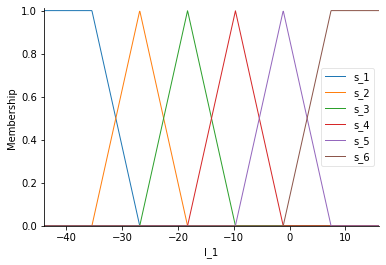

In [11]:
antecedents[0].view()

In [12]:
rules,df_rules = extract_rules(config, antecedents, consequents, X_train, y_train)
print('number of rules:', len(df_rules))

number of rules: 17


In [13]:
df_rules.head(10)

,I_1,I_2,O_1,Dr
0,s_1,s_1,s_7,0.497508
1,s_1,s_3,s_9,0.908072
2,s_1,s_4,s_10,0.460311
3,s_2,s_1,s_7,0.601737
4,s_2,s_3,s_11,0.709890
5,s_2,s_4,s_11,0.639872
6,s_3,s_1,s_7,0.555431
7,s_3,s_2,s_12,0.761011
8,s_3,s_3,s_12,0.755391
9,s_3,s_4,s_12,0.581660


In [14]:
%time system = ctrl.ControlSystem(rules)

CPU times: user 73.1 ms, sys: 1.94 ms, total: 75 ms
Wall time: 76.4 ms


In [15]:
%time sim = ctrl.ControlSystemSimulation(system)

CPU times: user 93 µs, sys: 11 µs, total: 104 µs
Wall time: 107 µs


In [16]:
def evaluate_model(sim, x_data, y_data, return_results=False):
  y_prev = []
  for x in x_data:
      for i,x_i in enumerate(x,1):
          sim.input['I_{}'.format(i)]=x_i
      sim.compute()
      result = sim.output['O_1']
      y_prev.append(result)
      
  mse = mean_squared_error(y_data, y_prev)
  
  print('mean_squared_error: {}'.format(mse))

  plt.figure(figsize=(15,5))
  plt.plot(y_data,'*')
  plt.plot(y_prev,'s')
  plt.show()

  y_data, y_prev = np.squeeze(np.array(y_data)), np.array(y_prev)
  table_results = pd.DataFrame()
  table_results['Real']=y_data
  table_results['Predicted']=y_prev
  table_results['Diference']=np.abs(y_data - y_prev) 
  table_results['Diference (%)']=np.abs((y_data - y_prev) / y_data)
  if return_results:
    return table_results

mean_squared_error: 3.6991561296242055


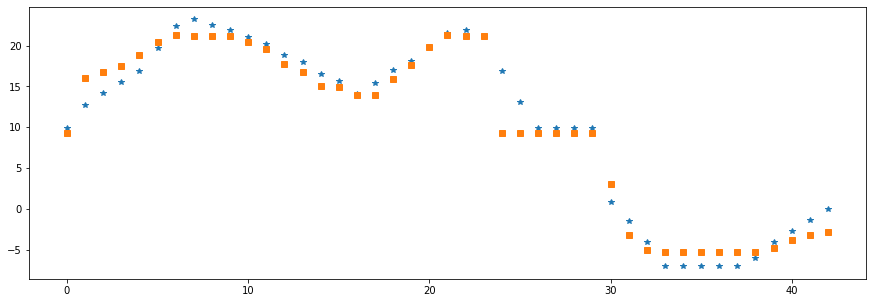

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


In [17]:
results=evaluate_model(sim, X, y_true, return_results=True)

In [18]:
results.head()

,Real,Predicted,Diference,Diference (%)
0,9.96,9.248560,0.711440,0.071430
1,12.75,16.021576,3.271576,0.256594
2,14.14,16.823712,2.683712,0.189796
3,15.54,17.521649,1.981649,0.127519
4,16.93,18.902398,1.972398,0.116503


mean_squared_error: 3.8912387147594036


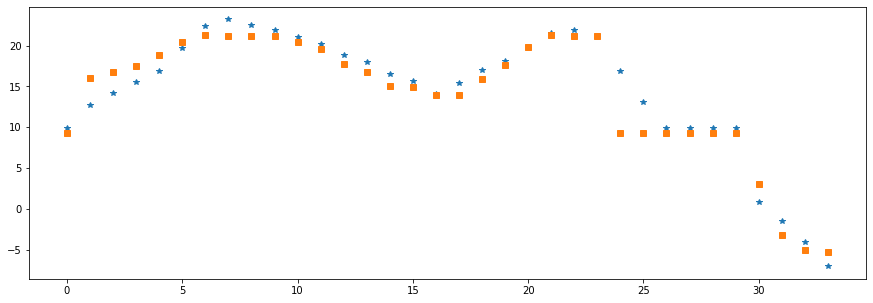

In [19]:
evaluate_model(sim, X_train, y_train)

mean_squared_error: 2.9735108080023402


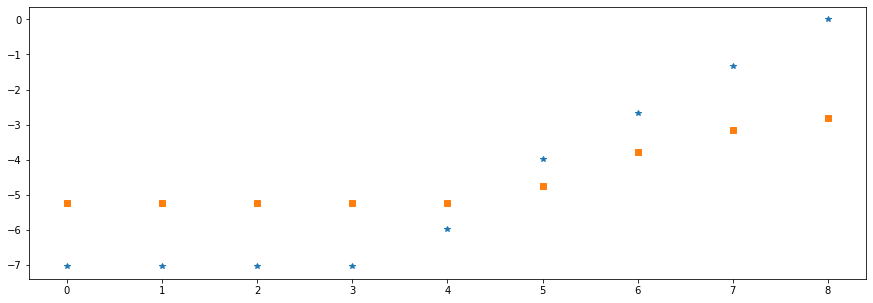

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
evaluate_model(sim, X_test, y_test)